# Shap explanation of XGBoost Classifier

This demo is on lightgbm classification. Check out the similarities and differences with [RandomForestClassifier](https://github.com/MenaWANG/ML_toy_examples/blob/main/explain%20models/shap_basic_RF_classification.ipynb) and [XGBoost Classifier](https://github.com/MenaWANG/ML_toy_examples/blob/main/explain%20models/shap_XGB_classification.ipynb) in the same repo.

In [1]:
import math
import numpy as np
np.set_printoptions(formatter={'float':lambda x:"{:.4f}".format(x)})
import pandas as pd
pd.options.display.float_format = "{:.4f}".format
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='rainbow')
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import lightgbm as lgb 
import shap #v0.39.0
shap.initjs()


# Import sample data
df =  sns.load_dataset('titanic')
df['is_male'] = df['sex'].map({'male': 1, 'female': 0}) # Encode
# Keep numerical complete columns
df = df.select_dtypes('number').dropna() 
X = df.drop(columns=['survived'])
y = df['survived']
# Partition data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}\n")
print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")
display(X_train.head())
# Train a simple model
model = lgb.LGBMClassifier(random_state=42, verbose=-1)
model.fit(X_train, y_train)

Training features shape: (571, 6)
Training target shape: (571,)

Test features shape: (143, 6)
Test target shape: (143,)


,pclass,age,sibsp,parch,fare,is_male
830,3,15.0000,1,0,14.4542,0
565,3,24.0000,2,0,24.1500,1
148,2,36.5000,0,2,26.0000,1
105,3,28.0000,0,0,7.8958,1
289,3,22.0000,0,0,7.7500,0


LGBMClassifier(random_state=42, verbose=-1)

We can see from the results below that
* Just like in [regression](https://github.com/MenaWANG/ML_toy_examples/blob/main/explain%20models/shap_basic_regression.ipynb) and [RF classifier](https://github.com/MenaWANG/ML_toy_examples/blob/main/explain%20models/shap_basic_RF_classification.ipynb), shap_test.data is the same with X_test. 
* However, unlike for [RF classifier](https://github.com/MenaWANG/ML_toy_examples/blob/main/explain%20models/shap_basic_RF_classification.ipynb), the XGBoost classifier doesn't have `values` and `base_values` for the negative and positive class respectively.

In [6]:
# get the explainer and create shap values
explainer = shap.Explainer(model)
shap_test = explainer(X_test)
print(f"Length of shap_test: {len(shap_test)}\n")
print(f"Sample shap_test for the first case:\n{shap_test[0]}")

Length of shap_test: 143

Sample shap_test for the first case:
.values =
array([[-1.3945, 1.3945],
       [-0.0804, 0.0804],
       [-0.1652, 0.1652],
       [0.0035, -0.0035],
       [0.2320, -0.2320],
       [-2.8062, 2.8062]])

.base_values =
array([0.4804, -0.4804])

.data =
array([1.0000, 15.0000, 0.0000, 1.0000, 211.3375, 0.0000])


In [8]:
# Like RF classifiers (but unlike XGBoost), the shap_test contains contributions for both class
shap_test.shape

(143, 6, 2)

## Base Value

Unlike for [RandomForest Clssifier](https://github.com/MenaWANG/ML_toy_examples/blob/main/explain%20models/shap_basic_RF_classification.ipynb) where both the base_values and expected_value is the probability for both class. The lightGBM and XGBoostClassifier result relate to raw maginal contributions and need to be transformed to probabilities (see below).


In [10]:
print(f"Expected value: {explainer.expected_value[1]:.2f}")
print(f"Average target value (training data): {y_train.mean():.2f}")
print(f"Base value: {shap_test.base_values[0][1]:.2f}")

Expected value: -0.48
Average target value (training data): 0.41
Base value: -0.48


## Shap Values
Shap values are the marginal contributions for each feature. 

In [11]:
shap_df = pd.DataFrame(shap_test.values[:,:,1], 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df

,pclass,age,sibsp,parch,fare,is_male
689,1.3945,0.0804,0.1652,-0.0035,-0.2320,2.8062
278,-0.5678,2.5827,-2.6768,-0.1773,-1.2433,-0.7170
506,0.7065,0.5310,0.1645,-0.0485,-0.4394,3.1357
9,0.8238,0.7882,0.1440,-0.0540,-0.0604,2.7216
494,-0.6003,-1.1412,0.0396,-0.0642,-0.1317,-0.9839
...,...,...,...,...,...,...
581,1.5531,0.0065,0.0734,-0.0964,1.6548,2.9755
44,-1.3139,0.5384,0.0827,-0.1647,-0.6148,1.9581
234,-0.3391,-1.5163,0.0361,-0.0915,-1.1212,-1.6656
781,1.6970,0.1151,0.0668,-0.1108,1.0383,2.9674


Like in [regression explanation](https://github.com/MenaWANG/ML_toy_examples/blob/main/explain%20models/shap_basic_regression.ipynb) and [RF classifier](https://github.com/MenaWANG/ML_toy_examples/blob/main/explain%20models/shap_basic_RF_classification.ipynb), adding up shap values and the base values should give us the predicted value, which is confirmed below. Note that we need to output raw predicted margins (or logits) by defining `raw_score = True` when making the predictions, same when working with [XGBoost Classifier](https://github.com/MenaWANG/ML_toy_examples/blob/main/explain%20models/shap_XGB_classification.ipynb).

In [18]:
np.isclose(model.predict(X_test, raw_score=True), 
           explainer.expected_value[1] + shap_df.sum(axis=1))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

To transform raw margin to probabilities, we need to employ sigmoid function. The raw_margin is positive when the predicted probability is higher than 0.5, and negative when the predicted probability is lower than 0.5.

In [21]:
y_prob = model.predict_proba(X_test)
y_pred_margin = model.predict(X_test, raw_score = True)
sig_transform = pd.DataFrame({
    'raw_margin': y_pred_margin,
    'predicted_probability': y_prob[:,1]
})
# transform the margin into probability using sigmoid function
from scipy.special import expit
sig_transform['sig_transform'] = expit(sig_transform['raw_margin'])
sig_transform.head()

,raw_margin,predicted_probability,sig_transform
0,3.7304,0.9766,0.9766
1,-3.2800,0.0363,0.0363
2,3.5695,0.9726,0.9726
3,3.8828,0.9798,0.9798
4,-3.3623,0.0335,0.0335


## Shap Built-in Plots

### Global | Feature Importance

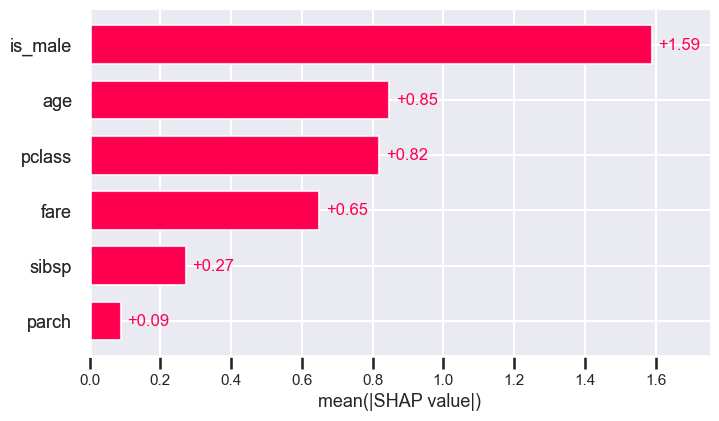

In [22]:
shap.plots.bar(shap_test[:,:,1])

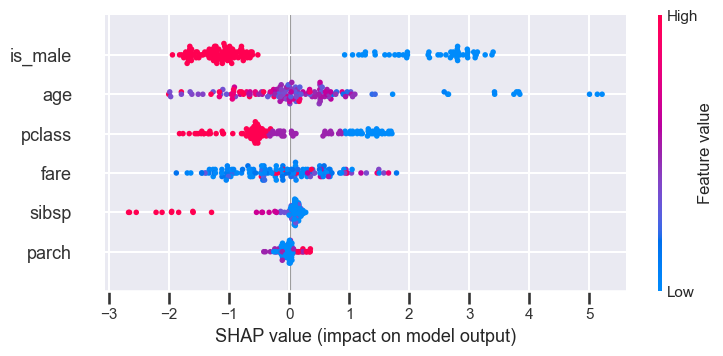

In [23]:
shap.summary_plot(shap_test[:,:,1])

### Local | Waterfall

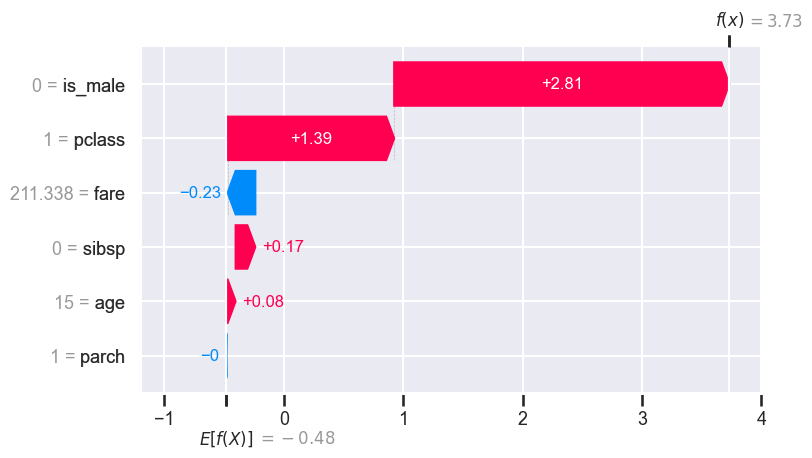

In [24]:
shap.plots.waterfall(shap_test[:,:,1][0])